In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install pretty_midi

In [5]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional
import os

In [4]:
root_dir = '/content/drive/MyDrive/music'

以sample file為例

In [6]:
midi_file_path = "/content/drive/MyDrive/music/Vou_levar_voce.mid"
pm = pretty_midi.PrettyMIDI(midi_file_path)

In [13]:
print('Number of instruments:', len(pm.instruments))
for instrument in pm.instruments:
  print(pretty_midi.program_to_instrument_name(instrument.program))

Number of instruments: 9
Electric Bass (finger)
Acoustic Guitar (steel)
Synth Strings 1
Harmonica
Acoustic Grand Piano
Electric Guitar (clean)
Acoustic Guitar (steel)
Synth Brass 1
Acoustic Grand Piano


取音符，包含pitch(音質)、note(音高)、duration(持續時間)

In [16]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=65, note_name=F4, duration=0.0674
1: pitch=65, note_name=F4, duration=0.0674
2: pitch=65, note_name=F4, duration=0.0674
3: pitch=65, note_name=F4, duration=0.0613
4: pitch=65, note_name=F4, duration=0.0674
5: pitch=66, note_name=F#4, duration=0.0429
6: pitch=65, note_name=F4, duration=0.0674
7: pitch=65, note_name=F4, duration=0.0674
8: pitch=65, note_name=F4, duration=0.0674
9: pitch=65, note_name=F4, duration=0.0735


建成DataFrame(以單一樂器為例)

In [17]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)
  # 以音符開始時間為index進行排序
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [19]:
raw_notes = midi_to_notes(midi_file_path)
raw_notes.head()

,pitch,start,end,step,duration
0,33,9.411760,9.699750,0.000000,0.287990
1,33,9.852936,10.042887,0.441176,0.189951
2,37,9.999995,10.312495,0.147059,0.312500
3,40,10.294113,10.563720,0.294118,0.269608
4,31,10.588230,10.931367,0.294118,0.343137


呈現整首歌各音符的時間軌跡

In [20]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

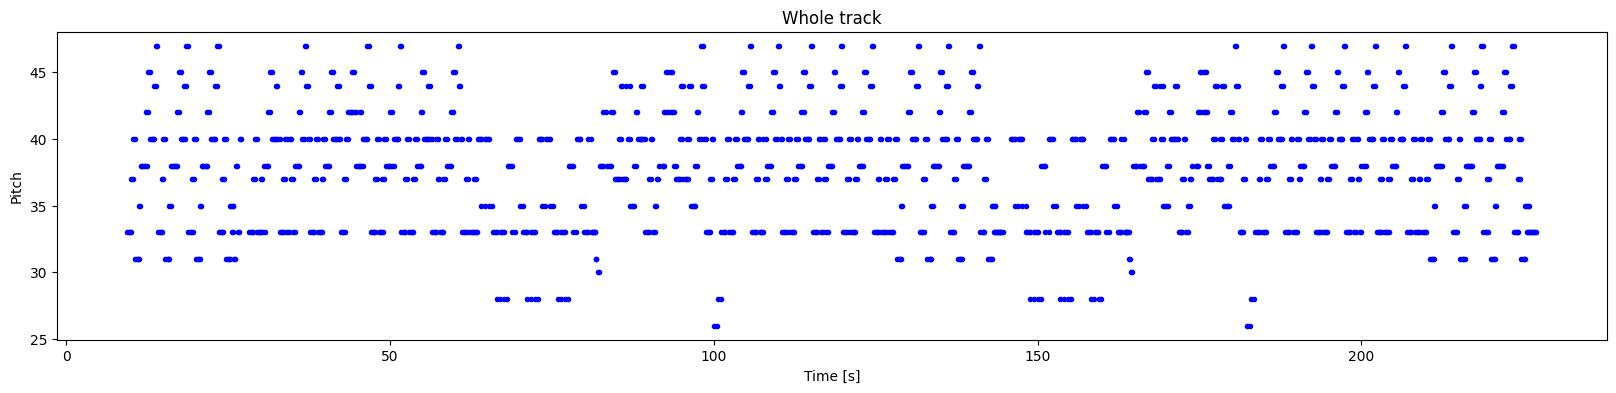

In [21]:
plot_piano_roll(raw_notes)

音高分布

In [22]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

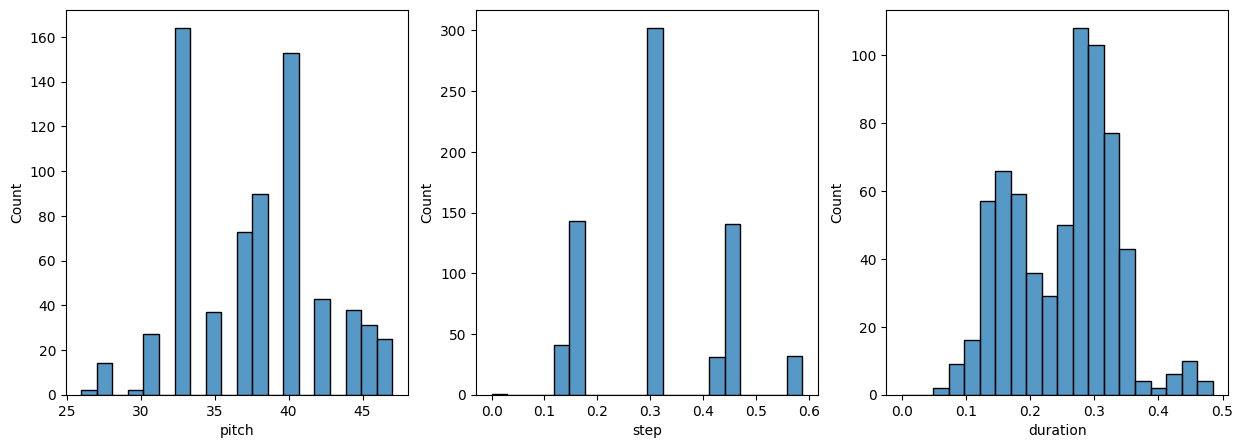

In [23]:
plot_distributions(raw_notes)

In [25]:
filenames = ['Fala_Serio.mid','Felicidade,_que_saudade_de_voce.mid','Passou_Da_Conta.mid',
             'Redeas_do_possante.mid','Volta_pro_meu_coracao.mid','Vou_levar_voce.mid']

In [28]:
all_notes=[]
for f in filenames:
  file_path = os.path.join(root_dir,f)
  notes = midi_to_notes(file_path)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [52]:
n_notes=len(all_notes)

In [30]:
print('len all notes:',len(all_notes))

len all notes: 6515


pack 成tensor

In [42]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [37]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # 正規化
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

長度設為25(hyperparameter)

In [98]:
seq_length = 10
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

sequence shape: (10, 3)
sequence elements (first 10): tf.Tensor(
[[0.328125   0.         0.07499992]
 [0.28125    0.         0.24642832]
 [0.34375    0.2142855  0.0571428 ]
 [0.359375   0.2142855  0.35357107]
 [0.28125    0.         1.11785603]
 [0.328125   0.428571   0.28214257]
 [0.3125     0.         0.47499953]
 [0.328125   0.428571   0.23571405]
 [0.3125     0.2142855  0.79642777]
 [0.328125   0.2142855  0.24642833]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=36.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.2142854999999999>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.08571419999999996>}


建立並訓練模型

In [54]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

參數搜尋

In [109]:
best_model=None
best_loss={'loss':float('inf')}
best_parameters=None
batches=[16,32,64]
seq_lengths=[10,25,50]
learning_rates=[0.001,0.005,0.01]
for seq in seq_lengths:
  seq_length = seq
  vocab_size = 128
  seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
  seq_ds.element_spec


  buffer_size = n_notes - seq_length  # the number of items in the dataset
  for batch_size in batches:
    train_ds = (seq_ds.shuffle(buffer_size).batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

    for lr in learning_rates:
      print(f'batch size: {batch_size},seq length: {seq},learning rate: {lr}')
      input_shape = (seq_length, 3)
      inputs = tf.keras.Input(input_shape)
      x = tf.keras.layers.LSTM(128)(inputs)

      outputs = {
        'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
        'step': tf.keras.layers.Dense(1, name='step')(x),
        'duration': tf.keras.layers.Dense(1, name='duration')(x),
      }
      model = tf.keras.Model(inputs, outputs)
      loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
        }

      optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

      model.compile(loss=loss, optimizer=optimizer)
      losses = model.evaluate(train_ds, return_dict=True)
      if losses.get("loss")<best_loss.get('loss'):
        best_model=model
        best_loss = losses
        best_parameters={'batch size': batch_size,'seq length': seq_length,'learning rate': lr}



<_PrefetchDataset element_spec=(TensorSpec(shape=(16, 10, 3), dtype=tf.float64, name=None), {'pitch': TensorSpec(shape=(16,), dtype=tf.float64, name=None), 'step': TensorSpec(shape=(16,), dtype=tf.float64, name=None), 'duration': TensorSpec(shape=(16,), dtype=tf.float64, name=None)})>
batch size: 16,seq length: 10,learning rate: 0.001
406/406 [==============================] - 6s 6ms/step - loss: 5.7709 - duration_loss: 0.2463 - pitch_loss: 4.8501 - step_loss: 0.6745
batch size: 16,seq length: 10,learning rate: 0.005
406/406 [==============================] - 4s 7ms/step - loss: 6.2887 - duration_loss: 0.8043 - pitch_loss: 4.8510 - step_loss: 0.6334
batch size: 16,seq length: 10,learning rate: 0.01
406/406 [==============================] - 3s 5ms/step - loss: 6.2672 - duration_loss: 1.0655 - pitch_loss: 4.8501 - step_loss: 0.3516
<_PrefetchDataset element_spec=(TensorSpec(shape=(32, 10, 3), dtype=tf.float64, name=None), {'pitch': TensorSpec(shape=(32,), dtype=tf.float64, name=None), '

In [113]:
best_parameters

{'batch size': 32, 'seq length': 25, 'learning rate': 0.01}

In [111]:
best_model.summary()

Model: "model_61"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_62 (InputLayer)       [(None, 25, 3)]              0         []                            
                                                                                                  
 lstm_64 (LSTM)              (None, 128)                  67584     ['input_62[0][0]']            
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['lstm_64[0][0]']             
                                                                                                  
 pitch (Dense)               (None, 128)                  16512     ['lstm_64[0][0]']             
                                                                                           

In [110]:
best_loss

{'loss': 5.263518333435059,
 'duration_loss': 0.19253972172737122,
 'pitch_loss': 4.856057167053223,
 'step_loss': 0.21491926908493042}

In [59]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

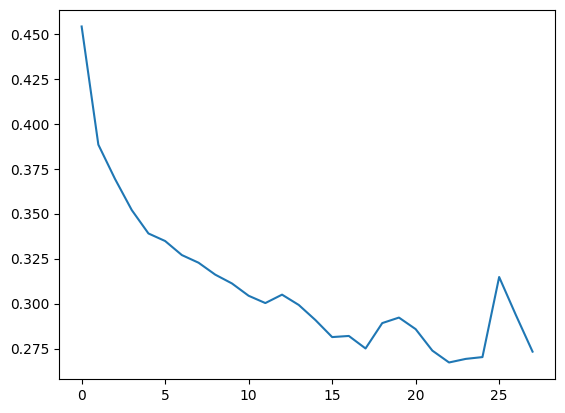

In [61]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [63]:
def predict_next_note(
    notes: np.ndarray,
    keras_model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [124]:
temperature = 2.0
num_predictions = 300

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:50] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, best_model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 35ms/step


In [66]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [70]:
_SAMPLING_RATE = 16000
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

In [122]:
from google.colab import files
files.download(out_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

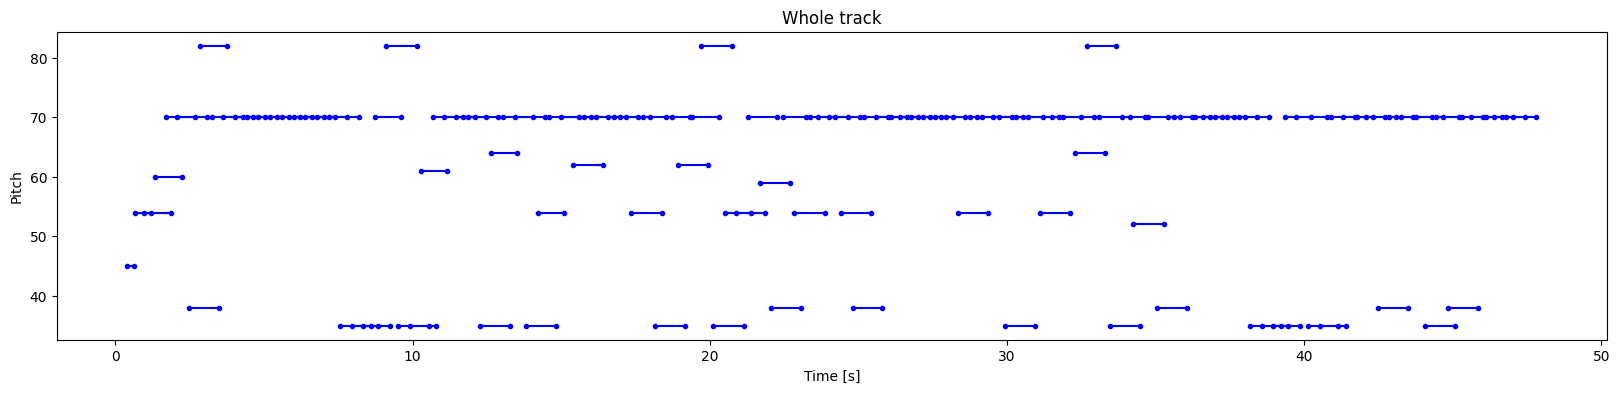

In [73]:
plot_piano_roll(generated_notes)

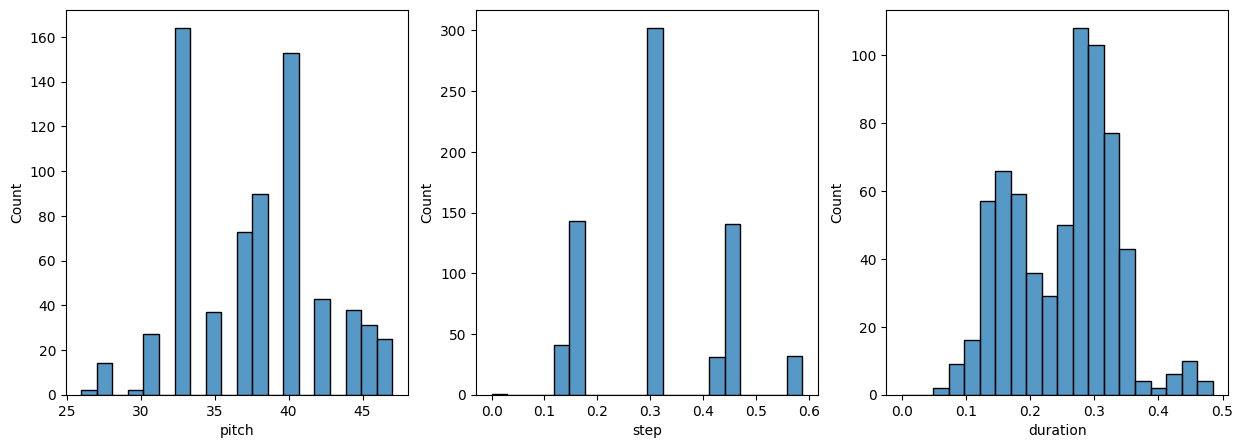

In [74]:
plot_distributions(raw_notes)